In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
plt.rcParams['figure.figsize'] = (13, 6)
plt.style.use('ggplot')

/Users/sobrison/anaconda/envs/nilmtk-env/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Estudio previo a la desagregación: búsqueda de patrones

Antes de realizar la desagregación, podemos obtener gráficas que nos ayuden a interpretar los datos. Tanto para el consumo agregado de la vivienda, como de los smart-plugs que nos dan el *"groundtruth"* de la desagregación. 

Cargamos REDD: 

In [3]:
from nilmtk import DataSet
redd=DataSet('data/redd.h5')

## Espectrograma

Teniendo en cuenta sólo en consumo agregado, podemos realizar esta especie de espectograma donde el eje-y es el día de la semana y el eje-x la hora del día. De esta forma, obtener información valiosa de cuando hay una mayor actividad en la casa

Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.

Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=11, building=2, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.

Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=10, building=4, dataset='REDD')     
Done loading data all meters for this chunk.

Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=9, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=13, building=5, dataset='REDD')     
Done loading data all meter

/Users/sobrison/anaconda/envs/nilmtk-env/lib/python2.7/site-packages/pandas/core/index.py:4072: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return np.sum(name == np.asarray(self.names)) > 1
/Users/sobrison/anaconda/envs/nilmtk-env/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):


Done loading data all meters for this chunk.


/Users/sobrison/anaconda/envs/nilmtk-env/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


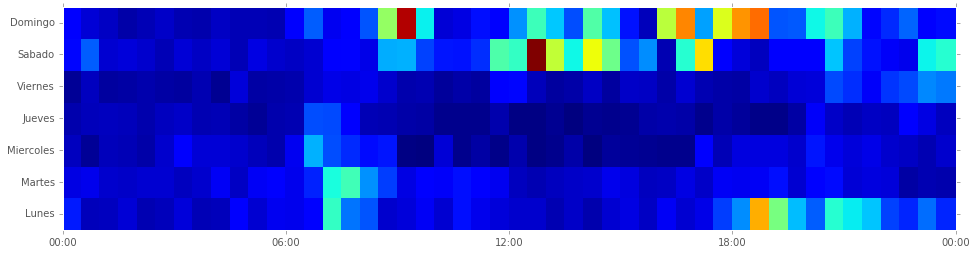

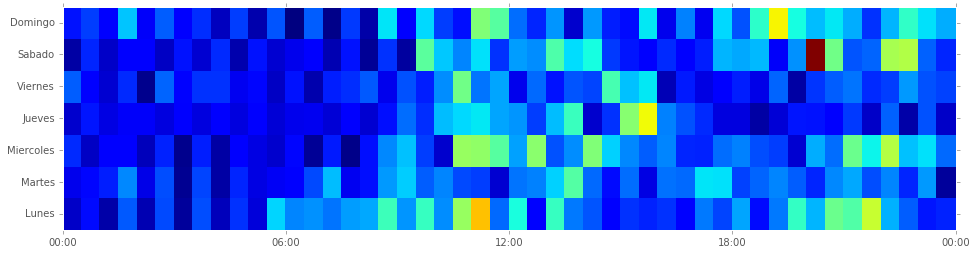

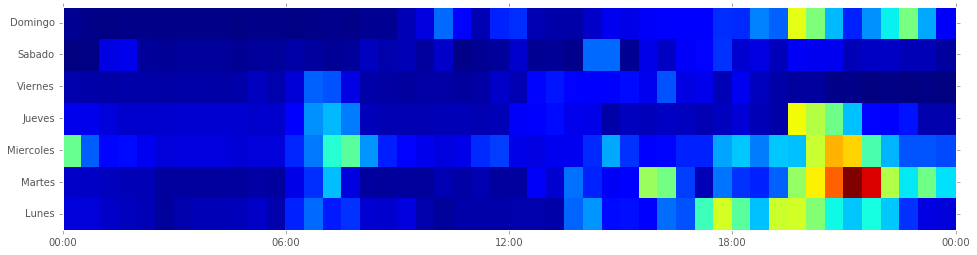

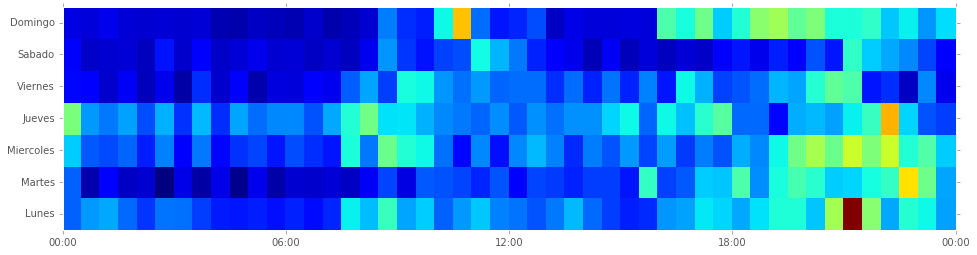

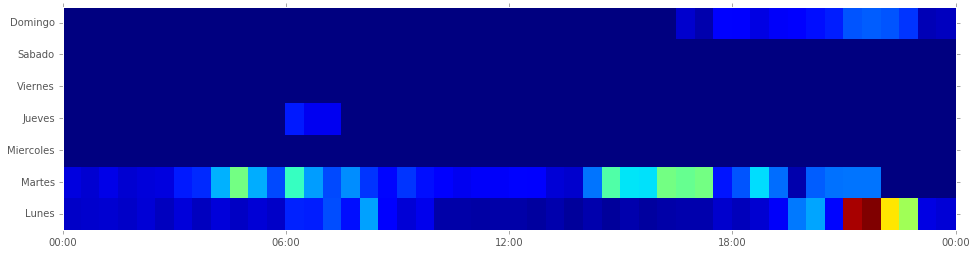

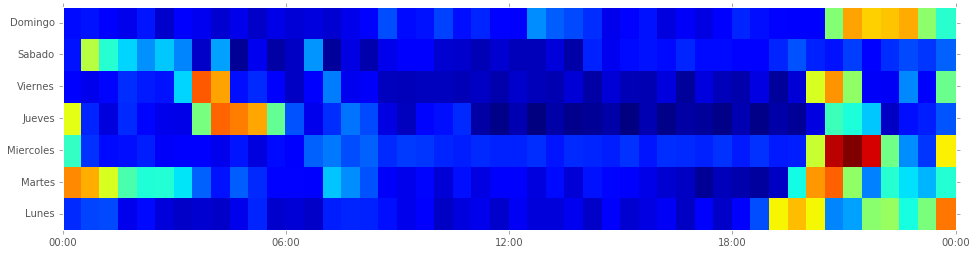

In [4]:
for building in np.arange(1,len(redd.buildings)+1):     
    df=redd.buildings[building].elec.power_series_all_data(sample_period=60*30).to_frame()
    df.fillna(0,inplace=True)
    df.columns=['apparent']
    df['weekday']=df.index.weekday
    df['time']=df.index.time
    matrix=df.groupby(['weekday','time']).apparent.mean().unstack().values
    plt.figure(figsize=(16, 4))
    ax = plt.gca()
    plt.pcolor(matrix)
    plt.xlim([0,48])
    ax.set_xticks(np.arange(0,49,12))
    ax.set_xticklabels(['00:00','06:00','12:00','18:00','00:00'])
    ax.set_yticks(np.arange(0.5,7))
    ax.set_yticklabels(['Lunes','Martes','Miercoles','Jueves','Viernes','Sabado','Domingo'])

- **Casa 1 (patrón regular):** De lunes a jueves actividad de 7:00 a 9:00 am. Lunes actividad a partir de las 18:00. Viernes poca actividad. Sabados y domingos alta actividad a partir de las 10:00

- **Casa 2 (patrón iregular):** Actividad media-alta durante la noche muy distribuida. Posible transtorno del sueño. Actividad también distribuida durante el día, posiblemente trabaja desde casa. 

- **Casa 3 (patrón regular):** Baja actividad los viernes y sabados por la tarde. Medianamente comienza su actividad a la misma hora del día de lunes a viernes 

- **Casa 4 (patrón iregular):** Actividad media-alta durante la noche excepto viernes,sabados y domingos. Presumiblemente pasa muchos fines de semana fuera de casa. Actividad distribuida durante el día. 

- **Casa 5 (patrón anómalo):** Posiblemente no se recopilaron los datos debidamente. 

- **Casa 6 (patrón regular):** Alta actividad a partir de las 18:00 execpto sabados donde la actividad se traslada por la noche. Martes y jueves noche alta actividad por la noche. Posible rutina nocturna de trabajo.

# Patrones de uso 

Si disponemos de las huellas de consumo de dispositivos individuales, bien por haber realizado una desagregación o por tener smart-plugs instalados, podemos obtener información más detallada de uso de cada dispositivo. 

Usaremos la base de datos ukdale. Esta tiene un mayor número de dispositivos que la de redd y se ha monitorizado durante más tiempo (2 años), lo cual nos puede dar patrones de uso mas reales. 

In [8]:
ukdale=DataSet('data/ukdale.h5')

In [9]:
elecs=ukdale.buildings[1].elec
elecs

MeterGroup(meters=
  ElecMeter(instance=2, building=1, dataset='UK-DALE', appliances=[Appliance(type='boiler', instance=1)])
  ElecMeter(instance=3, building=1, dataset='UK-DALE', appliances=[Appliance(type='solar thermal pumping station', instance=1)])
  ElecMeter(instance=4, building=1, dataset='UK-DALE', appliances=[Appliance(type='laptop computer', instance=1), Appliance(type='laptop computer', instance=3)])
  ElecMeter(instance=5, building=1, dataset='UK-DALE', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=6, building=1, dataset='UK-DALE', appliances=[Appliance(type='dish washer', instance=1)])
  ElecMeter(instance=7, building=1, dataset='UK-DALE', appliances=[Appliance(type='television', instance=1)])
  ElecMeter(instance=8, building=1, dataset='UK-DALE', appliances=[Appliance(type='light', instance=1), Appliance(type='light', instance=2)])
  ElecMeter(instance=9, building=1, dataset='UK-DALE', appliances=[Appliance(type='HTPC', instance=1)])
  Ele

Elegimos un dispositivo, extraemos el dataframe con su consumo y etiquetamos por horas. 

In [11]:
label='light'
elec=elecs[label]
elec
df=elec.load().next()
columns = [''.join(col).strip() for col in df.columns.values]
df.columns=columns
df['hour']=df.index.hour
df.head()

,powerapparent,hour
2012-11-12 18:24:46+00:00,0,18
2012-11-12 18:24:52+00:00,0,18
2012-11-12 18:24:59+00:00,0,18
2012-11-12 18:25:05+00:00,0,18
2012-11-12 18:25:11+00:00,0,18


Agrupamos la potencia aparente por horas mediante la suma y dividimos entre la potencia aparente total. 

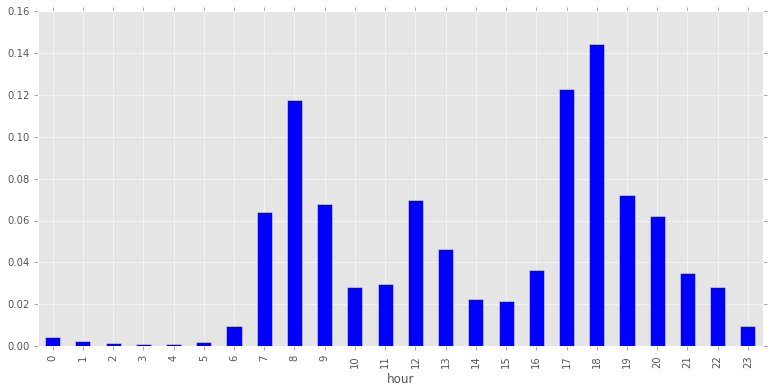

In [12]:
pattern=df.groupby('hour').sum()[columns[0]]/df[columns[0]].sum()
pattern.plot(kind='bar')

Podemos comprobar como durante las horas de sueño, las luces permanecen apagadas. 

Lo mismo para los días de la semana: 

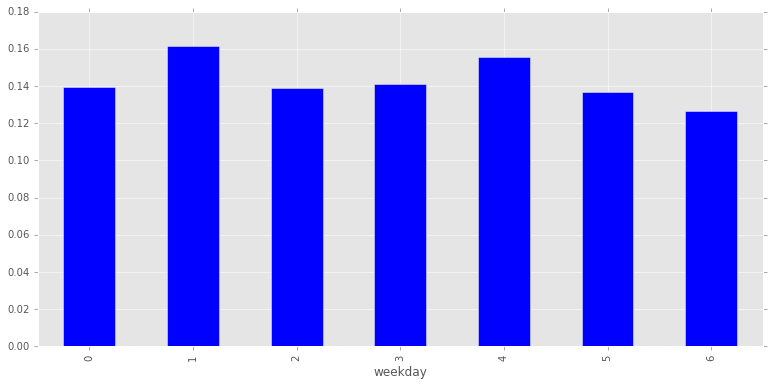

In [13]:
df['weekday']=df.index.weekday
pattern=df.groupby('weekday').sum()[columns[0]]/df[columns[0]].sum()
pattern.plot(kind='bar')

La probabilidad de usar las luces es la misma respecto a los días de la semana. 

De esta forma podemos hacernos una idea de cuales son las horas y los días que mas se utiliza dicho dispositivo. Lo cual puede ayudarnos posteriormente a entrenar nuestros algoritmos de desagregación. 

Otro caso de patrón semanal puede extraerse de la aspiradora. Cuyo uso es claramente mayor en sábado 

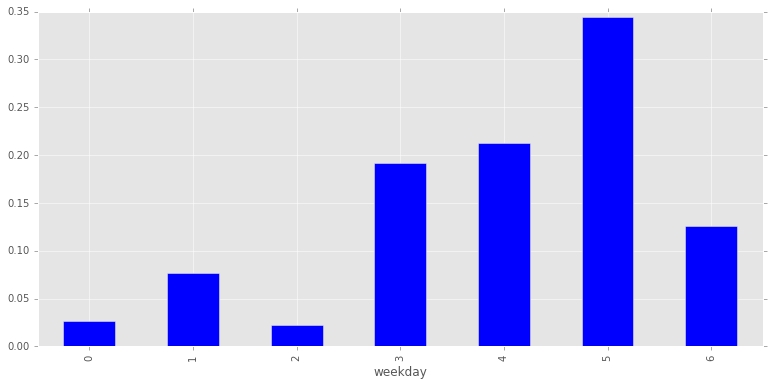

In [21]:
label='vacuum cleaner'
elec=elecs[label]
elec
df=elec.load().next()
columns = [''.join(col).strip() for col in df.columns.values]
df.columns=columns
df['hour']=df.index.hour
df['weekday']=df.index.weekday
pattern=df.groupby('weekday').sum()[columns[0]]/df[columns[0]].sum()
pattern.plot(kind='bar')

# Ejercicio  

Explora los patrones de uso **mensuales** de los distintos dispositivos en la base de datos ukdale. 

¿Encuentras algún patrón de uso predominante el algúno de ellos?

En tal caso, ¿qué dispositivo? 

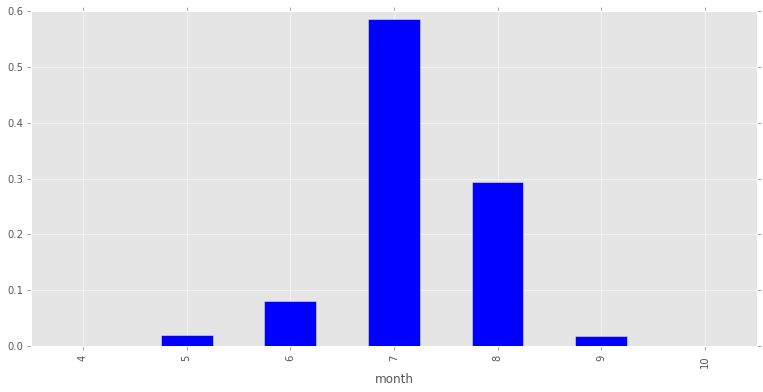

In [24]:
label='fan'
elec=elecs[label]
elec
df=elec.load().next()
columns = [''.join(col).strip() for col in df.columns.values]
df.columns=columns
df['month']=df.index.month
pattern=df.groupby('month').sum()[columns[0]]/df[columns[0]].sum()
pattern.plot(kind='bar')